In [11]:
# set up a GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1"


In [12]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from datautils import GenDataset
from networkmodels import Network1, load_network, save_network, parameters_to_csv


In [13]:
# test GPU working (output should be "Using -- cuda")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print( "Using --", device )

Using -- cuda


In [14]:
# load build data set 
filename = '../sim-data/population-sample.csv'

pred_vars_to_use = ["Age", "Sex", "MDD_hx", "Rx_hx", "Py_hx", "Sev", "Dur", "MDD_dx"]
target_var_to_use = ["Offer_Rx"]

# instantiate the data loader for the actual data
train_data = GenDataset( filename, pred_vars_to_use, target_var_to_use, trainflag = True )
test_data = GenDataset( filename, pred_vars_to_use, target_var_to_use, trainflag = False )



In [15]:


train_loader = DataLoader(train_data, batch_size=len( train_data ), shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size= len( test_data), shuffle = True, num_workers=2 )

# print( len( train_loader ) )
# print( len( test_loader ) )

# print( len( train_data ))
# print( len( test_data ) )

In [16]:
# establish input/output dimensions
train_x, train_y = next(iter(train_loader))

input_size = train_x[0].shape[0]
output_size = train_y[0].shape[0]



In [17]:
# learning params
learn_rate = 0.005

# instantiate network
model = Network1(input_size, output_size)
print( model.parameters )

print(f" Total Activations = {model.total_activations}")

# define loss and optimizer algorithm
criterion_train = nn.BCELoss(reduction = 'mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

# define a separate loss for measuring validation performance
criterion_valid = nn.BCELoss(reduction = 'mean')


<bound method Module.parameters of Network1(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)>
 Total Activations = 2


In [18]:
epochs = 50

train_loss_epoch = np.zeros(epochs)
test_loss_epoch = np.zeros(epochs)

N_train = len( train_data )
N_test = len( test_data )

# load stuff onto GPU
model.to(device)

for epoch in range(epochs):
  train_running_loss = 0.0
  test_running_loss = 0.0
  
  # training for one epoch
  model.train()
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
    # forward propagation
    outputs = model(inputs)
    loss = criterion_train(outputs, labels)
    # backward propagation
    loss.backward()
    # optimize
    optimizer.step()
    # this line sums the loss over one epoch
    train_running_loss += loss.item() 

  # out-of-sample performance for one epoch of training
  model.eval() ## switches off dropout and batchnorm layer behaviours
  with torch.no_grad(): ## disable gradient calculation
    for test_inputs, test_labels in test_loader:
      test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
      test_outputs = model( test_inputs )
      test_loss = criterion_valid( test_outputs, test_labels )
      test_running_loss += test_loss.item()
      

  train_loss_epoch[epoch] = train_running_loss / N_train
  test_loss_epoch[epoch]  = test_running_loss / N_test
  print("Completed Epoch ", epoch)

  if epoch % 10 == 9:
    save_network( model, 'small', epoch)



Completed Epoch  0
Completed Epoch  1
Completed Epoch  2
Completed Epoch  3
Completed Epoch  4
Completed Epoch  5
Completed Epoch  6
Completed Epoch  7
Completed Epoch  8
Completed Epoch  9
Completed Epoch  10
Completed Epoch  11
Completed Epoch  12
Completed Epoch  13
Completed Epoch  14
Completed Epoch  15
Completed Epoch  16
Completed Epoch  17
Completed Epoch  18
Completed Epoch  19
Completed Epoch  20
Completed Epoch  21
Completed Epoch  22
Completed Epoch  23
Completed Epoch  24
Completed Epoch  25
Completed Epoch  26
Completed Epoch  27
Completed Epoch  28
Completed Epoch  29
Completed Epoch  30
Completed Epoch  31
Completed Epoch  32
Completed Epoch  33
Completed Epoch  34
Completed Epoch  35
Completed Epoch  36
Completed Epoch  37
Completed Epoch  38
Completed Epoch  39
Completed Epoch  40
Completed Epoch  41
Completed Epoch  42
Completed Epoch  43
Completed Epoch  44
Completed Epoch  45
Completed Epoch  46
Completed Epoch  47
Completed Epoch  48
Completed Epoch  49


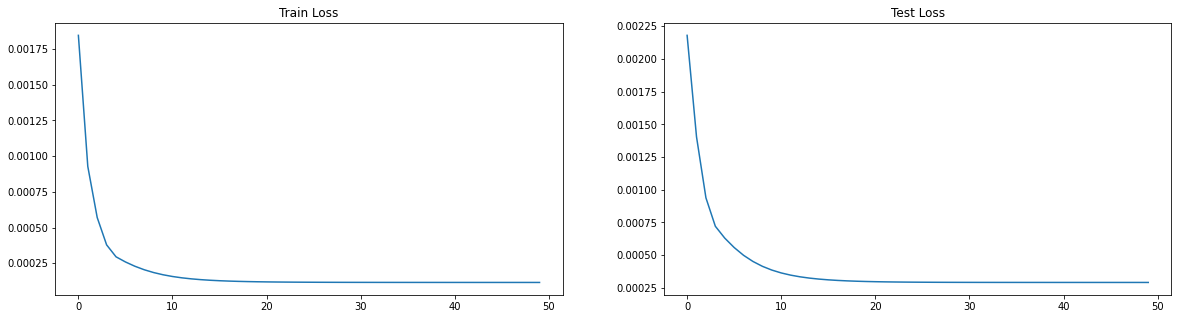

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots( 1,2, figsize = (20, 5) )
ax1.plot( list(range(0,len(train_loss_epoch))), train_loss_epoch )
ax2.plot( list(range(0,len(train_loss_epoch))), test_loss_epoch )
ax1.title.set_text('Train Loss')
ax2.title.set_text('Test Loss')